In [68]:
import pandas as pd
import datetime
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.lines as line

import seaborn as sns

import statsmodels as sm

from math import sqrt

from scipy import stats
from scipy.odr import *
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

In [69]:
data=pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')
data['data'] = pd.to_datetime(data['data'])
data['data'] = data['data'].dt.strftime('%d/%m/%Y')
data.index=data['data']
data['totale_attualmente_positivi']=data['totale_attualmente_positivi']/60483973
data.drop('data',axis=1)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,
24/02/2020,ITA,101,26,127,94,0.000004,221,1,7,229,4324,NaN,NaN
25/02/2020,ITA,114,35,150,162,0.000005,90,1,10,322,8623,NaN,NaN
26/02/2020,ITA,128,36,164,221,0.000006,74,3,12,400,9587,NaN,NaN
27/02/2020,ITA,248,56,304,284,0.000010,203,45,17,650,12014,NaN,NaN
28/02/2020,ITA,345,64,409,412,0.000014,233,46,21,888,15695,NaN,NaN
29/02/2020,ITA,401,105,506,543,0.000017,228,50,29,1128,18661,NaN,NaN
01/03/2020,ITA,639,140,779,798,0.000026,528,83,34,1694,21127,NaN,NaN
02/03/2020,ITA,742,166,908,927,0.000030,258,149,52,2036,23345,NaN,NaN
03/03/2020,ITA,1034,229,1263,1000,0.000037,428,160,79,2502,25856,NaN,NaN


In [70]:
data.index.to_series(index=range(data.index.size))

0     24/02/2020
1     25/02/2020
2     26/02/2020
3     27/02/2020
4     28/02/2020
5     29/02/2020
6     01/03/2020
7     02/03/2020
8     03/03/2020
9     04/03/2020
10    05/03/2020
11    06/03/2020
12    07/03/2020
13    08/03/2020
14    09/03/2020
15    10/03/2020
16    11/03/2020
17    12/03/2020
18    13/03/2020
19    14/03/2020
20    15/03/2020
21    16/03/2020
22    17/03/2020
23    18/03/2020
24    19/03/2020
25    20/03/2020
26    21/03/2020
27    22/03/2020
28    23/03/2020
29    24/03/2020
30    25/03/2020
31    26/03/2020
Name: data, dtype: object

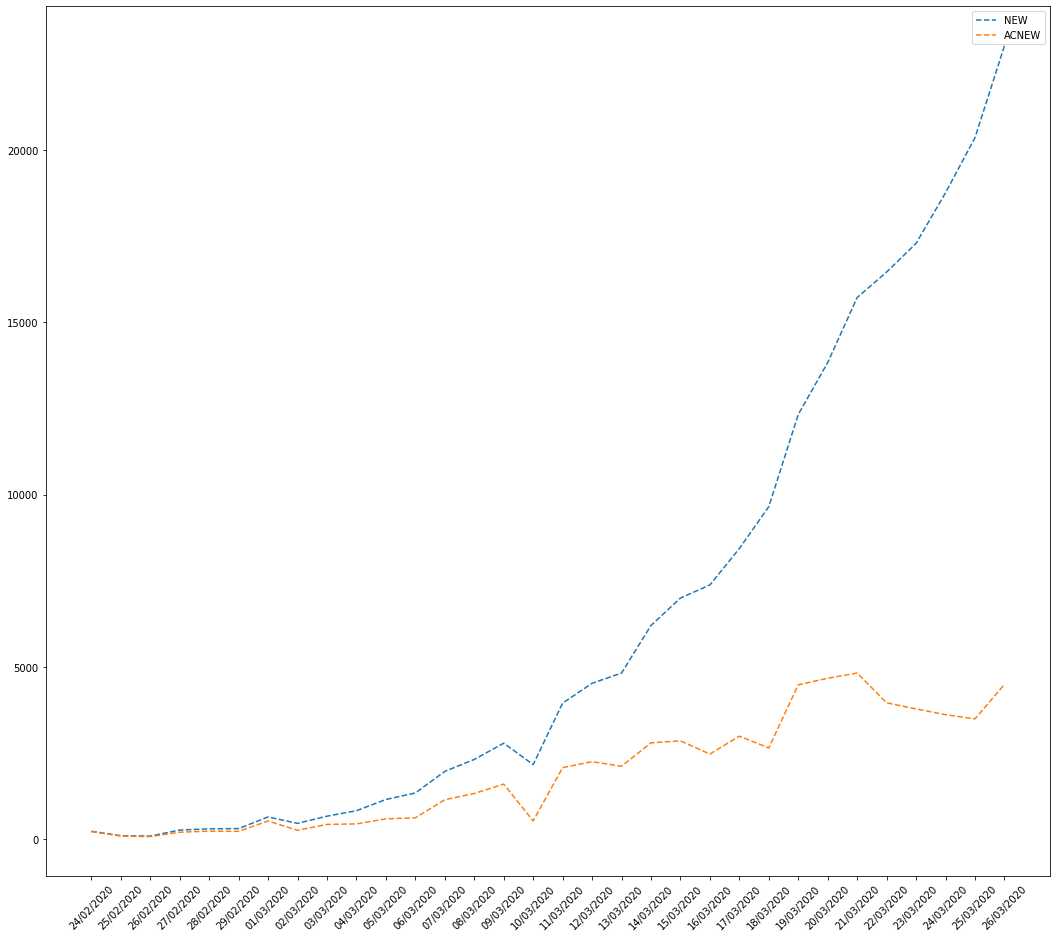

In [77]:
fig=plt.figure(figsize=(18,16))
new=fig.add_subplot(1,1,1)
#nooooooooooooooooo scemoooooo
new.plot(data.index,data['nuovi_attualmente_positivi']+data['dimessi_guariti']+data['deceduti'],'--',label='NEW')
new.plot(data.index,data['nuovi_attualmente_positivi'],'--',label='ACNEW')
plt.setp(new.xaxis.get_majorticklabels(), rotation=45)
new.legend()
#grw=fig.add_subplot(2,2,3)
#grw.plot(data.index,data['GRW'],'--',label='GRW')
#grw.plot(data.index,data['ACGRW'],'--',label='ACGRW')
#l = line.Line2D([13,25], [1,1])
#grw.add_line(l)
#grw.legend()

In [109]:
# time points
t=data.index.to_series(index=range(data.index.size))
t_fit=t[18:]
t_fitpre=t[:14]
t_fit=range(t_fit.size)
t_fitpre=range(t_fitpre.size)
t=range(t.size+30) 
tpre=range(t[-1]+18)
base = datetime.datetime.strptime('13/03/2020','%d/%m/%Y')
base2 = datetime.datetime.strptime('24/02/2020','%d/%m/%Y')
dlist =[base2 + datetime.timedelta(days=x) for x in range(200)]
mdate_list=[x for x in dlist if x<=datetime.datetime.strptime(data.index[-1],'%d/%m/%Y')]
date_list = [base + datetime.timedelta(days=x) for x in range(len(t))]
dpre_list=[x for x in dlist if x<date_list[-1]]
tpre

range(0, 79)

In [110]:
trans = 2.3 #rateo di trasmissione
recov = 0.6 #rateo di recovery
tmax = 60#numero di giorni fittizio
totpos=data['totale_attualmente_positivi']
guar=data['dimessi_guariti']/60483973
#initial conditions DCM1103
sstart = 1-totpos['13/03/2020']
rstart = guar['13/03/2020']
istart = totpos['13/03/2020']
#initial conditions DCM0803
sstart8 = 1-totpos['24/02/2020']
rstart8 = guar['24/02/2020']
istart8 = totpos['24/02/2020']

                    
#fit base
def modelI(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart,istart,rstart]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1] 
                    
#fit basepre
def modelIpre(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart8,istart8,rstart8]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1] 

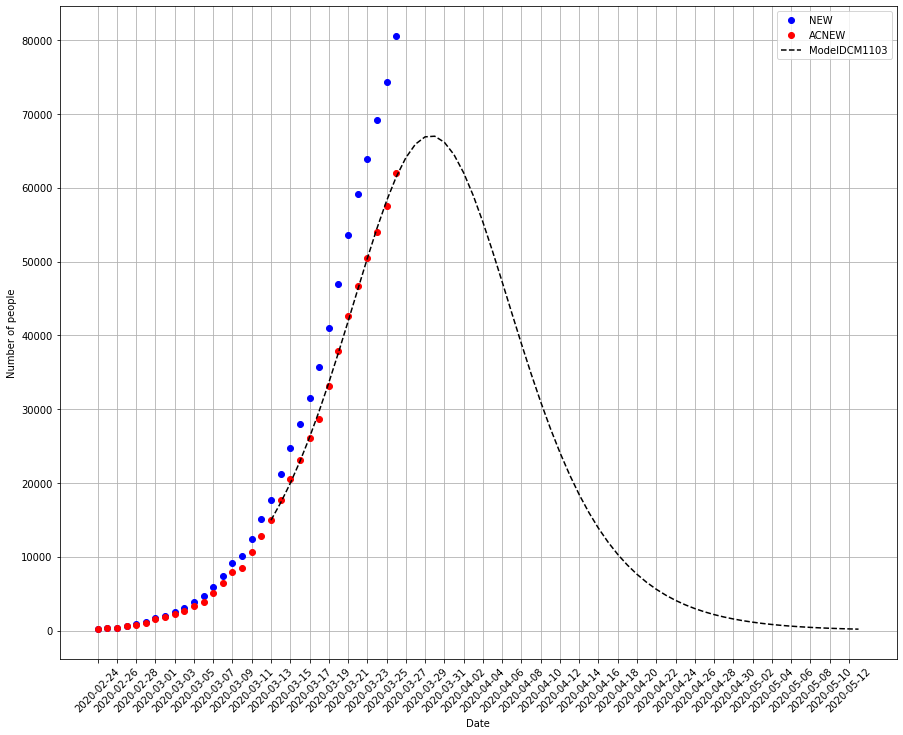

In [112]:
p,cov=curve_fit(modelI,t_fit,totpos['13/03/2020':],bounds=[[0,0],[+np.inf,+np.inf]])
trans,recov=p
curve_fit(modelIpre,t_fitpre,totpos['24/02/2020':'08/03/2020'],bounds=[[0,0],[+np.inf,+np.inf]])
fit=modelI(t,trans,recov)
fitpre=modelIpre(tpre,trans,recov)
fig2=plt.figure(figsize=(15,12))
tot=fig2.add_subplot(1,1,1)
tot.plot(mdate_list,data['totale_attualmente_positivi']*60483973+data['dimessi_guariti']+data['deceduti'],'bo',label='NEW')
tot.plot(mdate_list,data['totale_attualmente_positivi']*60483973,'ro',label='ACNEW')
tot.plot(date_list,fit*60483973,'k--',label='ModelDCM1103')
#tot.plot(dpre_list,fitpre*60483973,'r--',label='ModelpreDCM0803')
tot.legend()
tot.set_xlabel('Date')
tot.set_ylabel('Number of people')
tot.set_xticks([base2 + datetime.timedelta(days=2*x) for x in range(40)])
plt.setp(tot.xaxis.get_majorticklabels(), rotation=45)
tot.grid(True)

In [82]:
p

array([3.583069  , 3.43451348])